The Following Part is for testing and figuring out the icp_matching algorithm

In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np

#  ICP parameters
EPS = 0.0001
MAX_ITER = 100

show_animation = False

def icp_matching(previous_points, current_points):
    """
    Iterative Closest Point matching
    - input
    previous_points: 2D points in the previous frame
    current_points: 2D points in the current frame
    - output
    R: Rotation matrix
    T: Translation vector
    """
    H = None  # homogeneous transformation matrix

    dError = np.inf
    preError = np.inf
    count = 0

    while dError >= EPS:
        count += 1

        if show_animation:  # pragma: no cover
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect(
                'key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
            print(previous_points)
            plt.plot(previous_points[0, :], previous_points[1, :], ".r")
            plt.plot(current_points[0, :], current_points[1, :], ".b")
            plt.plot(0.0, 0.0, "xr")
            plt.axis("equal")
            plt.pause(0.1)

        indexes, error = nearest_neighbor_association(previous_points, current_points)
        Rt, Tt = svd_motion_estimation(previous_points[:, indexes], current_points)
        # update current points
        current_points = (Rt @ current_points) + Tt[:, np.newaxis]

        dError = preError - error
        #print("Residual:", error)

        if dError < 0:  # prevent matrix H changing, exit loop
            print("Not Converge...", preError, dError, count)
            break

        preError = error
        H = update_homogeneous_matrix(H, Rt, Tt)

        if dError <= EPS:
            print("Converge", error, dError, count)
            break
        elif MAX_ITER <= count:
            print("Not Converge...", error, dError, count)
            break

    R = np.array(H[0:2, 0:2])
    T = np.array(H[0:2, 2])

    return R, T

def nearest_neighbor_association(previous_points, current_points):

    # calc the sum of residual errors
    delta_points = previous_points - current_points
    d = np.linalg.norm(delta_points, axis=0)
    error = sum(d)

    # calc index with nearest neighbor assosiation
    d = np.linalg.norm(np.repeat(current_points, previous_points.shape[1], axis=1)
                       - np.tile(previous_points, (1, current_points.shape[1])), axis=0)
    indexes = np.argmin(d.reshape(current_points.shape[1], previous_points.shape[1]), axis=1)

    return indexes, error

def svd_motion_estimation(previous_points, current_points):
    pm = np.mean(previous_points, axis=1)
    cm = np.mean(current_points, axis=1)

    p_shift = previous_points - pm[:, np.newaxis]
    c_shift = current_points - cm[:, np.newaxis]

    W = c_shift @ p_shift.T
    u, s, vh = np.linalg.svd(W)

    R = (u @ vh).T
    t = pm - (R @ cm)

    return R, t

def update_homogeneous_matrix(Hin, R, T):

    H = np.zeros((3, 3))

    H[0, 0] = R[0, 0]
    H[1, 0] = R[1, 0]
    H[0, 1] = R[0, 1]
    H[1, 1] = R[1, 1]
    H[2, 2] = 1.0

    H[0, 2] = T[0]
    H[1, 2] = T[1]

    if Hin is None:
        return H
    else:
        return Hin @ H

Example Dataset taken from collected Data. Each entry in the following two lists reprisents a list of corners

In [3]:
a = [[-6.92815248148497e-05, -0.8820000263660182, 0.1], [0.037618182586186724, -0.8091260549264384, 0.1], [6.00664109084529, -0.8099308697470523, 0.1], [6.028639569155887, -0.9562018944154599, 0.1], [6.4145250457582454, 1.206483739886647, 0.1], [6.418810622560391, 0.6730470247167204, 0.1], [6.072963828554314, 2.369911021616298, 0.1], [6.083178649634356, 1.5150264568048768, 0.1], [-0.27463504424923507, 1.4614188013584368, 0.1], [3.7147096641198076, 1.4996561097437668, 0.1], [-0.22824266651659975, 0.6394891026266802, 0.1]]
b = [[-0.02571941021713099, -0.8816249561166412, 0.1], [0.009348445836983195, -0.8089460002059186, 0.1], [5.996730550954318, -0.8085945401624879, 0.1], [5.9624668437079595, -0.9457062453214801, 0.1], [6.395852407415333, 1.2029716740079106, 0.1], [6.147278188727962, 1.4930671696706423, 0.1], [-0.24965077618880974, 0.6400340145192047, 0.1]]
a = np.array(a)[:,:-1]
b = np.array(b)[:,:-1]

In [3]:
corners = [[[-6.92815248148497e-05, -0.8820000263660182, 0.1], [0.037618182586186724, -0.8091260549264384, 0.1], [6.00664109084529, -0.8099308697470523, 0.1], [6.028639569155887, -0.9562018944154599, 0.1], [6.4145250457582454, 1.206483739886647, 0.1], [6.418810622560391, 0.6730470247167204, 0.1], [6.072963828554314, 2.369911021616298, 0.1], [6.083178649634356, 1.5150264568048768, 0.1], [-0.27463504424923507, 1.4614188013584368, 0.1], [3.7147096641198076, 1.4996561097437668, 0.1], [-0.22824266651659975, 0.6394891026266802, 0.1]],
[[-0.02571941021713099, -0.8816249561166412, 0.1], [0.009348445836983195, -0.8089460002059186, 0.1], [5.996730550954318, -0.8085945401624879, 0.1], [5.9624668437079595, -0.9457062453214801, 0.1], [6.395852407415333, 1.2029716740079106, 0.1], [6.147278188727962, 1.4930671696706423, 0.1], [-0.24965077618880974, 0.6400340145192047, 0.1]],
[[6.008623009799263, -0.8101981101760845, 0.1], [5.936787819390843, -0.941633297948014, 0.1], [6.370300425327152, 1.1981656983992175, 0.1], [6.413660696568355, 0.6348099573963072, 0.1], [6.03942675092962, 2.356823525602925, 0.1], [-0.3214966441203805, 1.4733309053692327, 0.1], [3.680400119314488, 1.485805089572042, 0.1], [-0.2712811981271311, 0.639868411824738, 0.1]],
[[5.941423630592916, -0.8363557639415277, 0.1], [5.933183528004145, -0.9764773909778138, 0.1], [6.346713836131863, 1.1937293861016578, 0.1], [6.38181623531953, 0.631658063018812, 0.1], [6.021726700662943, 2.3499162649317964, 0.1], [6.070510098772212, 1.4744215331348782, 0.1], [-0.29311050883865075, 0.6389798450237497, 0.1]],
[[3.4482975201666655, -0.8180350034789711, 0.1], [5.932511197436346, -0.8351011883878068, 0.1], [5.892727403325797, -0.9698191625767323, 0.1], [6.3064204701066995, 1.1861507593774847, 0.1], [6.345991512988657, 0.6281122111983743, 0.1], [6.002163627487607, 2.342281978931784, 0.1], [6.0403857766704885, 1.4671048581841428, 0.1], [-0.36879663082772496, 1.481795619410512, 0.1], [3.648872453394176, 1.4730771347388454, 0.1], [-0.3114018957071664, 0.6391790792002606, 0.1]],
[[5.9572672216994365, -0.838586017087464, 0.1], [5.9047300030035865, -1.0071080190992863, 0.1], [6.316165048399948, 1.149982635079829, 0.1], [5.98912157870405, 2.3371924549317753, 0.1], [6.007346421800322, 1.4590801723721036, 0.1], [-0.38917207671250786, 1.4548474906655424, 0.1], [3.6331086204340197, 1.466713157322247, 0.1], [-0.3321532228996707, 0.6433119691742093, 0.1]],
[[3.3463737761281247, -0.8350954312688669, 0.1], [5.881050730389431, -0.8627752945754508, 0.1], [5.8416409428381915, -0.9963475781684246, 0.1], [6.294521030742562, 1.1460419140460016, 0.1], [6.319666948253436, 0.5884048034420385, 0.1], [5.971421528437373, 2.330285194260647, 0.1], [-0.41523921164093563, 1.4829621191344562, 0.1], [3.608999150818843, 1.4569799838900646, 0.1], [-0.3563579588029059, 0.6348173520467673, 0.1]],
[[5.883029406107707, -0.8630655747658398, 0.1], [5.870213464604731, -1.0363976821262786, 0.1], [6.269925278921701, 1.1415637714905138, 0.1], [6.285813448041026, 0.5852528078857199, 0.1], [5.953721478170697, 2.3233779335895184, 0.1], [-0.43360826757525545, 1.45057921067471, 0.1], [3.593235317858687, 1.4506160064734661, 0.1], [-0.3724281236794768, 0.6371352641116699, 0.1]],
[[5.911722562958953, -0.8672749835925164, 0.1], [5.807139333395792, -0.9904629996146893, 0.1], [6.237459017873149, 1.1356526472330404, 0.1], [6.2599253935050045, 0.5828424505416554, 0.1], [5.933226893541031, 2.315380134925064, 0.1], [5.9816739558613445, 1.4160471501320213, 0.1], [-0.3950202168422116, 0.6410679058282905, 0.1]],
[[5.816619480038655, -0.8879174347044747, 0.1], [5.774690669708549, -1.0195329456362754, 0.1], [6.198106002609749, 1.128487653309646, 0.1], [6.239015920560605, 0.5808956336573691, 0.1], [5.914595331820025, 2.3081093615894934, 0.1], [5.947615445194278, 1.4079844477307006, 0.1], [-0.4803224555161319, 1.4515961810635953, 0.1], [3.514429016548296, 1.4426335943489825, 0.1], [-0.4162422109601163, 0.6334875266278956, 0.1]],
[[5.824527765960428, -0.8891246487869273, 0.1], [5.755979990116006, -1.0162295385152833, 0.1], [6.220323607080054, 1.0951876797429556, 0.1], [6.262213815024397, 0.5463307607762311, 0.1], [5.904347817399456, 2.3041103755828107, 0.1], [5.921341670677911, 1.4017646330430988, 0.1], [-0.5082336039904336, 1.4780621986702984, 0.1], [3.5014775487346306, 1.437317162440372, 0.1], [-0.4373789967429058, 0.6409958258293346, 0.1]],
[[5.7669114143468825, -0.9146892190300124, 0.1], [5.7253774024885935, -1.0452060070681881, 0.1], [6.200626592449492, 1.091719704583825, 0.1], [6.207422107889305, 0.5415505990111499, 0.1], [5.88571625567845, 2.2968396022472404, 0.1], [5.888255730015725, 1.393932168029151, 0.1], [-0.4585841190298215, 0.6395855692101712, 0.1]],
[[5.784689309093367, -0.917508969064876, 0.1], [5.7116050774333775, -1.0426917768494517, 0.1], [6.170096055407266, 1.0863443141481048, 0.1], [6.178531563646985, 0.5390301176795674, 0.1], [5.867084693957444, 2.28956882891167, 0.1], [-0.5577013981680142, 1.4804368290457726, 0.1], [3.4570732094172816, 1.4190896804418895, 0.1], [-0.4756433956204667, 0.6395095314152466, 0.1]],
[[5.7141302500192985, -0.9404258223111466, 0.1], [5.673997106201751, -1.0699695215788332, 0.1], [6.119868503734478, 1.077500948553254, 0.1], [6.201496718037212, 0.5047018676572174, 0.1], [5.846590109327778, 2.2815710302472154, 0.1], [-0.5672236458442805, 1.4295809400476, 0.1], [-0.4971621508087836, 0.6369410029718192, 0.1]],
[[5.718076867690051, -0.941075352686894, 0.1], [5.657291812134021, -1.0668193339479748, 0.1], [6.1437782518135835, 1.0449005535504927, 0.1], [6.150665136122616, 0.5005649962704037, 0.1], [5.83634259490721, 2.2775720442405327, 0.1], [5.850466758189862, 1.3490948654015382, 0.1], [-0.6050744655951719, 1.4746935998226824, 0.1], [3.4311704943493386, 1.4084569071618176, 0.1], [-0.5207739116167399, 0.6514219969293263, 0.1]],
[[5.658288861159763, -0.9650751318951888, 0.1], [5.620560947999339, -1.0937889048549667, 0.1], [6.119132065426861, 1.0407088635605757, 0.1], [6.11179361889827, 0.4974014813587959, 0.1], [5.819574056094863, 2.2710282962338466, 0.1], [5.81051531208676, 1.3398822174145018, 0.1], [-0.6315582067942402, 1.4896504053588302, 0.1], [3.4098933507632876, 1.3997228789642098, 0.1], [-0.5422136560815669, 0.6467924096532517, 0.1]],
[[5.658288861159763, -0.9650751318951888, 0.1], [5.6170442768020346, -1.1270561838066209, 0.1], [6.092514334557009, 1.0361818639554132, 0.1], [5.79325245747983, 2.299677898173386, 0.1], [5.785180158042149, 1.334040029491992, 0.1], [-0.5645651043073806, 0.6500671873744585, 0.1]],
[[5.701662648779618, -0.9724729450565773, 0.1], [5.576845605083374, -1.1189903471657314, 0.1], [6.061953044633996, 1.030984165169923, 0.1], [6.094640492844842, 0.46033352250410353, 0.1], [5.77745164943374, 2.2934056410425994, 0.1], [5.760819361515631, 1.3284225246211183, 0.1], [-0.6758636469401391, 1.473380296360255, 0.1], [3.38676615503199, 1.3902294251633351, 0.1], [-0.5803021023923257, 0.6681875175272545, 0.1]],
[[5.601371061041989, -0.9889330293347389, 0.1], [5.5770969615884765, -1.1528297516388544, 0.1], [6.05874249292935, 0.45762211519938206, 0.1], [5.766298633208005, 2.288978362048539, 0.1], [-0.6993716884084876, 1.4789778102287858, 0.1], [3.3710396090004546, 1.3837738548498248, 0.1], [-0.5974011198126138, 1.2262169978377668, 0.1]],
[[5.648639874469286, -0.9972784309062999, 0.1], [5.528132388444691, -1.1427083897394237, 0.1], [6.040217521360412, 0.9911694324456254, 0.1], [5.746779857622964, 2.2812302279663843, 0.1], [5.754789519167015, 1.2918221336430877, 0.1], [-0.7178448762840229, 1.4734381304580075, 0.1], [3.346987166637146, 1.3739005977101681, 0.1]],
[[5.573881357796572, -1.0175493890275424, 0.1], [5.505741636220826, -1.1715170248578066, 0.1], [5.983969628833443, 0.981939435096182, 0.1], [6.024391838608589, 0.41979774750575316, 0.1], [5.735731806244599, 2.2383097295493237, 0.1], [-0.7371804543308921, 1.4694560739779352, 0.1], [3.32385975034646, 1.3644070533721449, 0.1]],
[[5.535439364616957, -1.0438411049265786, 0.1], [5.484223531964835, -1.1669383818439905, 0.1], [6.00340859658355, 0.9492997720177826, 0.1], [6.046691283451256, 0.38602005887457036, 0.1], [5.720826734552382, 2.2324931802204313, 0.1], [5.721174043371085, 1.2493632476928571, 0.1], [-0.6727075502705525, 1.2845095134298423, 0.1]],
[[5.495899685839243, -1.0695292078821113, 0.1], [5.451943694157588, -1.1932621747065437, 0.1], [5.9708454686416355, 0.3811780709962858, 0.1], [5.749865235036369, 1.2206296852115885, 0.1], [-0.7840522490092027, 1.4971179860748338, 0.1], [3.3067037824438965, 1.334941079878397, 0.1], [-0.6724314076303151, 1.2484231219529307, 0.1]],
[[5.467034314340429, -1.096956784995898, 0.1], [5.458152856585422, -1.2613381957351009, 0.1], [5.964341758704032, 0.9075913435243834, 0.1], [5.958985363800362, 0.34562767114392445, 0.1], [5.697303213247677, 2.185210054594478, 0.1], [5.674543626476104, 1.2046397815202257, 0.1], [-0.7900357760408743, 1.4667651135678297, 0.1], [3.277957774326267, 1.3233361011311382, 0.1]],
[[5.4876238436949505, -1.1010880603138653, 0.1], [5.398719332437941, -1.247603553982825, 0.1], [5.958636026768165, 0.8712889692439167, 0.1], [5.687966665026172, 2.181629006107994, 0.1], [-0.8196450391213421, 1.50076052063826, 0.1], [3.335052879646158, 1.3014697271839537, 0.1], [-0.7073313701338202, 1.2600426518222103, 0.1]],
[[5.432161227367376, -1.1228703968640512, 0.1], [5.380667384171615, -1.2764485188961516, 0.1], [5.928951483146585, 0.866948409542278, 0.1], [5.923945169864798, 0.3090299746843825, 0.1], [5.674894785176303, 2.176615265007825, 0.1], [5.656970749000308, 1.1665606361361134, 0.1], [-0.7542146354854163, 1.3254378802834466, 0.1]],
[[5.392281989857803, -1.147374971682957, 0.1], [5.3653780592751845, -1.3058352636029218, 0.1], [5.658088909335124, 2.170169343579768, 0.1], [-0.8595573646642984, 1.5105645499300349, 0.1], [3.2567875480439534, 1.2928078654008925, 0.1], [-0.7382958548949359, 1.263047268970138, 0.1]],
[[5.41771222230807, -1.1527860411137463, 0.1], [5.3216543344768805, -1.295193705623798, 0.1], [5.900224120228929, 0.8277206732669927, 0.1], [5.880690763714209, 0.27248142997240454, 0.1], [5.653420412618195, 2.16837873395556, 0.1], [5.628361021539632, 1.1265678220775321, 0.1], [-0.7848744285034838, 1.3249801436826412, 0.1]],
[[5.371839635731652, -1.175729869106509, 0.1], [5.297535607058861, -1.3220124464272085, 0.1], [5.888090939862159, 0.7911204512509774, 0.1], [5.882176329080674, 0.23826796200163397, 0.1], [5.659361192588638, 1.0985717319925805, 0.1], [-0.8939413819965496, 1.5091007398725436, 0.1], [3.2344423130892825, 1.2622074991671999, 0.1], [-0.7638618629208204, 1.255951885419664, 0.1]],
[[5.343445969481043, -1.202130093617522, 0.1], [5.26650425634783, -1.346860308995953, 0.1], [5.827633851257078, 0.7829974722231277, 0.1], [5.6266374070180545, 2.1206429124243646, 0.1], [5.577881923330849, 1.0827553140429291, 0.1], [-0.9145419876192886, 1.5235951563012196, 0.1], [3.206494970507773, 1.251301339163844, 0.1], [-0.7942372040043923, 1.2889466396738711, 0.1]],
[[5.304209965959061, -1.2257631480933655, 0.1], [5.241167622443757, -1.3729123609825806, 0.1], [5.841017029695806, 0.7502306019616497, 0.1], [5.814504536074264, 0.201654863965006, 0.1], [5.6172797390759115, 2.117116068456496, 0.1], [5.592931301770818, 1.0519532819271908, 0.1], [-0.8292578024692024, 1.3284155308550587, 0.1]],
[[5.267799692117055, -1.249673067438572, 0.1], [5.212809291597419, -1.3979383626808375, 0.1], [5.832378901099601, 0.7146587339580516, 0.1], [5.812580201698079, 0.16774106325362784, 0.1], [5.520500318213501, 1.1049785179854803, 0.1], [-0.9536994260369684, 1.5277626879635124, 0.1], [3.1838419687256074, 1.2211678441339469, 0.1], [-0.8220029480429009, 1.28331106971597, 0.1]]]

In [4]:
corner_counter = 0
start_point = np.array([0,0])
start_points = [start_point]

##### ICP output start #####
Converge 0.18787697373706858 1.9984014443252818e-15 3
##### ICP output end #####
##### ICP output start #####
Converge 0.06462457281067757 1.609823385706477e-15 3
##### ICP output end #####
##### ICP output start #####
Converge 0.11914818984560897 5.551115123125783e-17 3
##### ICP output end #####
##### ICP output start #####
Converge 0.11026940467999621 4.1772141301521515e-15 3
##### ICP output end #####
##### ICP output start #####
Converge 0.18008058094395468 3.0531133177191805e-16 3
##### ICP output end #####
##### ICP output start #####
Not Converge... 0.16664211499230186 -5.551115123125783e-16 3
##### ICP output end #####
##### ICP output start #####
Converge 0.14077625261615379 1.3877787807814457e-15 3
##### ICP output end #####
##### ICP output start #####
Converge 0.15576301399138204 3.0531133177191805e-16 3
##### ICP output end #####
##### ICP output start #####
Not Converge... 0.1588664904829156 -5.551115123125783e-16 3
##### ICP output end #####

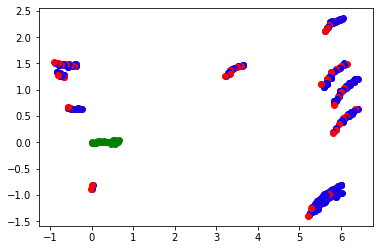

In [5]:
#a = [[-6.92815248148497e-05, -0.8820000263660182, 0.1], [0.037618182586186724, -0.8091260549264384, 0.1], [6.00664109084529, -0.8099308697470523, 0.1], [6.028639569155887, -0.9562018944154599, 0.1], [6.4145250457582454, 1.206483739886647, 0.1], [6.418810622560391, 0.6730470247167204, 0.1], [6.072963828554314, 2.369911021616298, 0.1], [6.083178649634356, 1.5150264568048768, 0.1], [-0.27463504424923507, 1.4614188013584368, 0.1], [3.7147096641198076, 1.4996561097437668, 0.1], [-0.22824266651659975, 0.6394891026266802, 0.1]]
#b = [[-0.02571941021713099, -0.8816249561166412, 0.1], [0.009348445836983195, -0.8089460002059186, 0.1], [5.996730550954318, -0.8085945401624879, 0.1], [5.9624668437079595, -0.9457062453214801, 0.1], [6.395852407415333, 1.2029716740079106, 0.1], [6.147278188727962, 1.4930671696706423, 0.1], [-0.24965077618880974, 0.6400340145192047, 0.1]]
while corner_counter + 1 < len(corners):
    a = corners[corner_counter]
    corner_counter += 1
    b = corners[corner_counter]
    a = np.array(a)[:,:-1]
    b = np.array(b)[:,:-1]

    # plt.plot(a[:,0],a[:,1], 'bo')
    # plt.plot(b[:,0],b[:,1], 'ro')
    # plt.title('Show All Points')
    # plt.xlim([-1, 7])
    # plt.ylim([-2, 2.5])
    # plt.show()

    # Idea: 
    # 1) check, if a near point in first array exists in second array
    # 2) keep only the corresponding pairs (TODO: delete doubles)
    # 3) cut down the arrays to same size (TODO: only corresponding points left)
    # 4) use icp as in PythonRobotics example



    # 1)
    from scipy.spatial import distance
    dist = distance.cdist(a, b, 'euclidean') # Compute distance between each pair of the two collections of inputs.
    min_row_index = np.argmin(dist, axis=0) # or axis=1 ?

    min_row_index = np.argmin(dist, axis=0)
    c = [[],[]]
    d = [[],[]]
    for i in range(len(min_row_index)):
        row_index = min_row_index[i]
        col_index = np.argmin(dist[row_index,:])
        # 2) TODO: save the pairs (not only print them)
        if dist[row_index,col_index] < 0.1: 
            #print(f"possible pair: ({row_index},{col_index}) with distance: {dist[row_index,col_index]}")
            c[0].append(a[row_index,0])
            c[1].append(a[row_index,1])
            d[0].append(b[col_index,0])
            d[1].append(b[col_index,1])
            plt.plot(a[row_index,0],a[row_index,1], 'bo')
            plt.plot(b[col_index,0],b[col_index,1], 'ro')
    # plt.xlim([-1, 7])
    # plt.ylim([-2, 2.5])
    # plt.title('Show Correspondig Pairs Only')
    # plt.show()

    c = np.array(c)
    d = np.array(d)

    # # 3) here, we are cutting randomly -> not good
    # # (because maybe points with good correlation are thrown away)
    # # keep all corresponding point candidates found


    # 4) use ICP
    # parameters
    EPS = 0.0001
    MAX_ITER = 100
    show_animation = False

    print('##### ICP output start #####')
    R, T = icp_matching(c, d)
    print('##### ICP output end #####')

    start_points.append(np.matmul(R, start_points[-1]) + T)

#print(start_points)
plt.plot(*zip(*[[pt[0], pt[1]] for pt in start_points]), 'go')
plt.show()
plt.close()
# print(f'R')
# print(R)
# print(f'T: {T}')

# theta1 = math.acos(R[0,0])
# theta2 = math.asin(R[0,1])
# theta3 = -math.asin(R[1,0])
# theta4 = math.acos(R[1,1])

# print(f'thetas: {theta1} {theta2} {theta3} {theta4}')

# #theta = 1.55617482041056 # assumed angle from above print-out (last cell)
# np.array([[math.cos(theta1),-math.sin(theta2)],[math.sin(theta3),math.cos(theta4)]])

# # idea: if not converged, leave out (?)

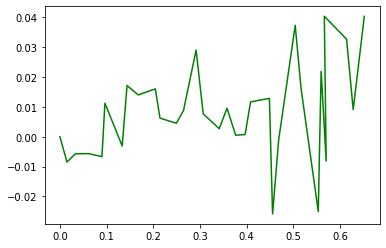

In [6]:
start_points
plt.plot(*zip(*[[pt[0], pt[1]] for pt in start_points]), 'g')
plt.show()
plt.close()

In [114]:
a1 = np.array([1,2])
b1 = np.array([[ 0.99999755,  0.00221458],
               [-0.00221458,  0.99999755]])
c1 = np.matmul(a1, b1)
print(c1)
print(i)

[0.99556839 2.00220968]
7


If we just tried to apply the icp_matching algorithm on both these datasets we would receive an error, as they do not contain the same amount of corners

For Testing and simplicity I have not tried to take every combination of 7 elements from the first list but instead am taking the consecutive points

In [9]:
len_a = len(a)
len_b = len(b)
for i in range(max(len_a, len_b) - min((len_a, len_b)) + 1):
    print(i, "to", i+len_b)
    print(icp_matching(a[i:i+len_b], b))
    print("-------------------------------------------------------------------")

0 to 7
Residual: 8.243366257977533
Residual: 1.0256938981898673
Residual: 1.0256938981898682
Not Converge... 1.0256938981898673 -8.881784197001252e-16 3
(array([[-0.120541  , -0.17461048],
       [-0.16196681,  0.00214861]]), array([0.58803852, 1.82050408]))
-------------------------------------------------------------------
1 to 8
Residual: 11.278737594148692
Residual: 1.773366139870845
Residual: 1.7733661398708445
Converge 1.7733661398708445 4.440892098500626e-16 3
(array([[ 0.0650527 , -0.07614529],
       [ 0.04137816, -0.03487286]]), array([-0.4552933 ,  0.84567647]))
-------------------------------------------------------------------
2 to 9
Residual: 11.507747795901116
Residual: 1.856284169824705
Residual: 1.8562841698247063
Not Converge... 1.856284169824705 -1.3322676295501878e-15 3
(array([[-0.21820266,  0.11174054],
       [-0.16404175,  0.1538116 ]]), array([-0.09789545,  1.16997057]))
-------------------------------------------------------------------
3 to 10
Residual: 15.86

In an attempt to manually do what this algorithm does I have put together the following

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.spatial import distance
import time
import math
from scipy.spatial.transform import Rotation as R


def getTriangles(set_X, X_combs):
    """
    Inefficient way of obtaining the lengths of each triangle's side.
    Normalized so that the minimum length is 1.
    """
    triang = []
    for p0, p1, p2 in X_combs:
        d1 = np.sqrt((set_X[p0][0] - set_X[p1][0]) ** 2 +
                     (set_X[p0][1] - set_X[p1][1]) ** 2)
        d2 = np.sqrt((set_X[p0][0] - set_X[p2][0]) ** 2 +
                     (set_X[p0][1] - set_X[p2][1]) ** 2)
        d3 = np.sqrt((set_X[p1][0] - set_X[p2][0]) ** 2 +
                     (set_X[p1][1] - set_X[p2][1]) ** 2)
        d_min = min(d1, d2, d3)
        d_unsort = [d1 / d_min, d2 / d_min, d3 / d_min]
        triang.append(sorted(d_unsort))

    return triang


def sumTriangles(A_triang, B_triang):
    """
    For each normalized triangle in A, compare with each normalized triangle
    in B. find the differences between their sides, sum their absolute values,
    and select the two triangles with the smallest sum of absolute differences.
    """
    tr_sum, tr_idx = [], []
    for i, A_tr in enumerate(A_triang):
        for j, B_tr in enumerate(B_triang):
            # Absolute value of lengths differences.
            tr_diff = abs(np.array(A_tr) - np.array(B_tr))
            # Sum the differences
            tr_sum.append(sum(tr_diff))
            tr_idx.append([i, j])

    # Index of the triangles in A and B with the smallest sum of absolute
    # length differences.
    tr_idx_min = tr_idx[tr_sum.index(min(tr_sum))]
    A_idx, B_idx = tr_idx_min[0], tr_idx_min[1]
    print("Smallest difference: {}".format(min(tr_sum)))

    return A_idx, B_idx

In [3]:
i = 0
start_point = [0,0,0]
start_points = [start_point]

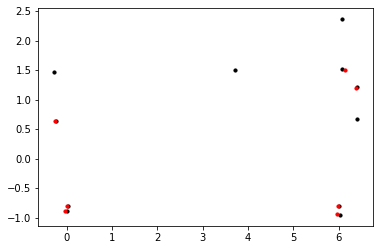

Smallest difference: 0.007662805798223538
triangle A (0, 4, 10) matches triangle B (0, 4, 6)
it took 0.35026073455810547 seconds


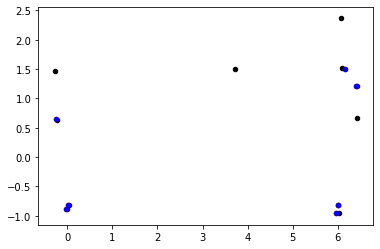

In [4]:
if i + 1 < len(corners):
    t0 = time.time()
    
    set_A = [[x[0], x[1]] for x in corners[i]]
    i += 1
    set_B = [[x[0], x[1]] for x in corners[i]]
    plt.scatter([row[0] for row in set_A], [row[1] for row in set_A], s=10, c='k')
    plt.scatter([row[0] for row in set_B], [row[1] for row in set_B], s=10, c='r')
    plt.show()
    plt.close()

    # All possible triangles.
    A_combs = list(itertools.combinations(range(len(set_A)), 3))
    B_combs = list(itertools.combinations(range(len(set_B)), 3))

    # Obtain normalized triangles.
    A_triang, B_triang = getTriangles(set_A, A_combs), getTriangles(set_B, B_combs)

    # Index of the A and B triangles with the smallest difference.
    A_idx, B_idx = sumTriangles(A_triang, B_triang)

    # Indexes of points in A and B of the best match triangles.
    A_idx_pts, B_idx_pts = A_combs[A_idx], B_combs[B_idx]
    print('triangle A %s matches triangle B %s' % (A_idx_pts, B_idx_pts))

    # Matched points in A and B.
#     print "A:", [set_A[_] for _ in A_idx_pts]
#     print "B:", [set_B[_] for _ in B_idx_pts]
    a = [corners[i-1][_] for _ in A_idx_pts]
    b = [corners[i][_] for _ in B_idx_pts]
    x = np.linalg.solve(a, b)
    
    t = np.matmul(corners[i-1], x)

#     new_set = []
#     for original,predicted in product(corners[i],t):
#         dist = distance.euclidean(original,predicted)
#         if dist < 1:
#             new_set.append(original)
    new_set = []
    for original in corners[i]:
        min_dist = 1
        partner_index = None
        for iterator, predicted in enumerate(t):
            dist = distance.euclidean(original,predicted)
            if dist < min_dist:
                min_dist = dist
                partner_index = iterator
        if min_dist < 1:
            new_set.append(original)
            t = np.delete(t, partner_index, 0)
                     
    t1 = time.time()

    print('it took', t1-t0, 'seconds')
    # Plot
    A_pts = zip(*[[pt[0], pt[1]] for pt in set_A])
    B_pts = zip(*[[pt[0], pt[1]] for pt in set_B])
    N_pts = zip(*[[pt[0], pt[1]] for pt in new_set])
    
    plt.scatter(*A_pts, s=20, c='k')
    plt.scatter(*B_pts, s=20, c='r')
    plt.scatter(*N_pts, s=20, c='b')
    
    plt.show()

In theory this kind of works. The main Problem I have been facing with this is, the resulting Matrix does not seem to yield the information on Rotation or Translation, which would be useful information, to determine odometry values.

One Idea that I had was to attempt to get the Transformation Matrix via some extra Steps, this however is also proving to be a challenge

In [126]:
def translation_matrix(vector):
    translation = np.identity(4)
    translation[0,3] = vector[0]
    translation[1,3] = vector[1]
    return translation

In [140]:
affine_a = np.ones((3,4))
affine_a[:,:-1] = np.array(a)
affine_b = np.ones((3,4))
affine_b[:,:-1] = np.array(b)
a_tmp = affine_a[0].reshape(4,1)

translation_pt_to_pt = translation_matrix(affine_a[0]-affine_b[0])
result = np.matmul(translation_pt_to_pt, a_tmp)[:3].reshape(1,3)
print("I think this should be the translation vector")
print(translation_pt_to_pt[:2,3:4])
radians = -math.atan2(*(b[0] - result)[0,:2])
print("I think this should be the rotation angle")
print(radians)
rotation = np.identity(4)#R.from_euler('zyx', [radians, 0, 0]).as_matrix()
rotation[:-1,:-1] = R.from_euler('zyx', [radians, 0, 0]).as_matrix()
print("And this the rotation matrix")
print(rotation)

translation_to_zero = translation_matrix(-affine_b[1][:2])
translation_from_zero = translation_matrix(affine_b[1][:2])

final_answer = np.matmul(translation_from_zero, 
                         np.matmul(rotation, np.matmul(translation_to_zero, 
                                                       np.matmul(translation_pt_to_pt, affine_a.transpose()))))
print("__________________________")
print(final_answer[:3,:].transpose())

print("But somewhere down the line mistakes are being made, so I am not coming to the right conclusion")

I think this should be the translation vector
[[ 0.02565013]
 [-0.00037507]]
I think this should be the rotation angle
1.55617482041056
And this the rotation matrix
[[ 0.01462099 -0.99989311  0.          0.        ]
 [ 0.99989311  0.01462099  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
__________________________
[[ 8.38783662 -5.19710878  0.1       ]
 [ 6.39336379  1.24733557  0.1       ]
 [ 6.86317401 -5.4030121   0.1       ]]
But somewhere down the line mistakes are being made, so I am not coming to the right conclusion
